In [1]:
using Distributions
using LinearAlgebra
using Plots
using Test
using Sobol
using Optim
using Profile
using PProf
using Random

In [61]:
include("../rollout.jl")
include("../testfns.jl")

TestGramacyLee (generic function with 1 method)

### Psuedo-code for Rollout Bayesian Optimization
1. Generate low-discrepancy sequence for Quasi-Monte Carlo
2. Gather initial samples/experimental data
3. Construct the ground truth surrogate model
4. Setup hyperparameters for stochastic gradient descent
5. While budget has not been exhausted
<ol>
    <li>
        Construct a batch of samples for stochastic gradient descent. For each sample
        <ol>
            <li>Create a copy of the ground truth surrogate at the sample location and the pairwise perturbed surrogate.</li>
            <li style="color: #f66">Initialize our trajectory struct with the fantasized surrogate and fantisized perturbed surrogate and fantasy start location.</li>
            <li>Perform rollout on the trajectory for $r$ steps $M_0$ times for Quasi-Monte Carlo integration.</li>
            <li>Update values for $\alpha$ and $\nabla\alpha$</li>
        </ol>
    </li>
    <li>Once SGD has converged, update sample location using update rule</li>
    <li>Save location and value at location for each sample in batch.</li>
    <li>Select the best sample from the batch and sample original process at new sample location.</li>
    <li>Update surrogate model with value found at new sample location.</li>
    <li>Repeat until budget is exhausted.</li>
</ol>

### Issues
- Use control variates to see how they affect the rollout acquisition functions

#### Probability of Improvement
The probability of improvement (POI) is defined as follows:

$$
POI(x) = \Phi\left( \frac{\mu(x) - f^+ - \xi}{\sigma(x)} \right)
$$

where $f^+$ denotes the best value (maximum) known, $\mu(x)$ is the predictive mean at x, $\sigma(x)$ is the predictive variance, $\xi$ is our exploration parameter, and $\Phi$ is the standard normal cumulative distribution function.
<hr>

#### Expected Improvement
The expected improvement (EI) is defined as follows:

$$
EI(x) = (\mu(x) - f^+ - \xi)\Phi\left( \frac{\mu(x) - f^+ - \xi}{\sigma(x)} \right) +
        \sigma(x)\phi\left(\frac{\mu(x) - f^+ - \xi}{\sigma(x)}\right)
$$

where $\phi$ is the standard normal probability density function.
<hr>

In [62]:
function ei(μ, σ, fbest)
    z = (fbest - μ) / σ
    Φz = Distributions.normcdf(z)
    ϕz = Distributions.normpdf(z)
    return σ*(z*Φz + ϕz)
end

function poi(μ, σ, fbest)
    z = (fbest - μ) / σ
    Φz = Distributions.normcdf(z)
    return Φz
end

poi (generic function with 1 method)

In [63]:
# Global parameters
MAX_SGD_ITERS = 1000
BATCH_SIZE = 3
HORIZON = 0
MC_SAMPLES = 100
BUDGET = 15;

### 1. Generate low-discrepancy sequence for Quasi-Monte Carlo

In [64]:
# Setup toy problem
# testfn = TestFunction(
#     1, [0. 1.], [.5],
#     x -> 0. + 1e-6*randn(),
#     ∇x -> [0. + 1e-6*randn()]
# )
testfn = TestGramacyLee()
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

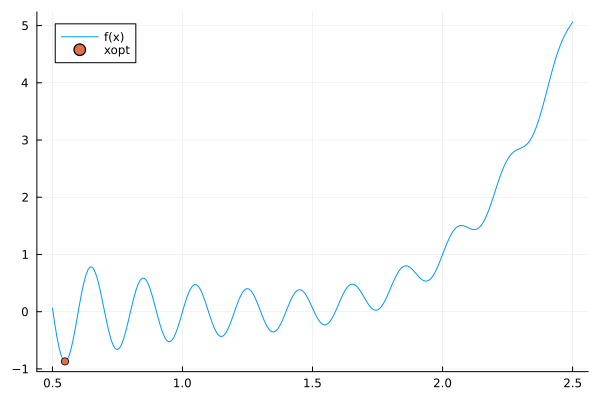

In [65]:
tplot(testfn)

### 2. Gather initial samples/experimental data

In [66]:
# Gather initial samples/experimental data
N, θ = 1, [.25]
# X = [.15, .85]
X = [2.0, 2.5]
X = reshape(X, 1, length(X))
# ψ = kernel_matern52(θ);
ψ = kernel_scale(kernel_matern52, [1., θ...]);

### 3. Construct the ground truth surrogate model

In [67]:
sur = fit_surrogate(ψ, X, testfn.f);
# θ, sur = optimize_hypers(ψ.θ, kernel_matern52, sur.X, testfn.f);

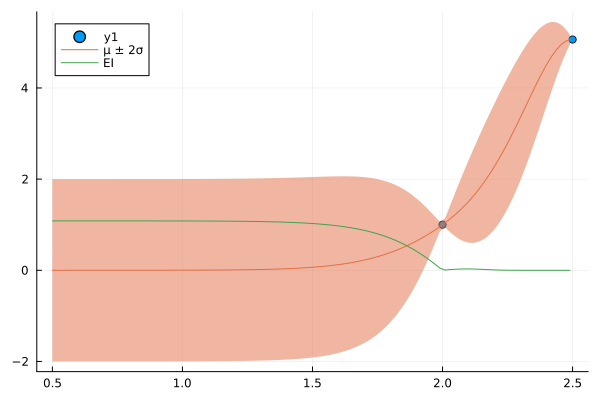

In [68]:
domain = filter(x -> !(x in X), lbs[1]:.01:ubs[1])
scatter(sur.X', sur.y)
plot!(domain, [sur([x]).μ for x in domain],
    ribbons=2*[sur([x]).σ for x in domain], label="μ ± 2σ")
plot!(domain, [sur([x]).EI for x in domain], label="EI")

### 4. Setup hyperparameters for stochastic gradient descent

In [69]:
λ = 5e-3; # Vanilla stochastic gradient descent

### 5. While budget has not been exhausted
Each location in our minibatch is going to be our $x^0$ that serves as our deterministic start location. Then, we perform rollout from that point forward, computing several sample trajectories to then be averaged.

We need a few mechanisms:
* We shouldn't sample at locations that are near known locations in sur.X
* We should perform the evaluations in parallel to save time

In [70]:
∇αxs = []
batch = []
ϵsgd, grad_tol = 1e-12, 1e-5
xs = []
final_locations = []

for b in 1:BUDGET
    batch = generate_batch(BATCH_SIZE + 10; lbs=lbs, ubs=ubs)
    batch = convert(Matrix{Float64}, filter(x -> !(x in sur.X), batch)')[:, 1:BATCH_SIZE]
    # batch = [.75 .5]
    batch_evals = []
    final_locations = []
    
    # This should be a parallel for loop
    println("---------- BO Iteration #$b ----------")
    bndx = 1
    for x0 in eachcol(batch)
        x0 = convert(Vector{Float64}, x0)
        
        αxs, ∇αxs = [], []
        ∇αxs = [0., 1., 2.]
        
        print("\n(Batch #$bndx - $x0) Gradient Ascent Iteration Count: ")
        # Run SGD until convergence
        fprev, fnow = 0., 1.
        for epoch in 1:MAX_SGD_ITERS
            if mod(epoch, 25) == 0 print("|") end
            
            αxi, ∇αxi = 0., [0.]
            # Perform Monte Carlo simulation
            for sample in 1:MC_SAMPLES
                fsur = Base.deepcopy(sur)
                fantasy_ndx = size(fsur.X, 2) + 1

                # Rollout trajectory
                T = Trajectory(fsur, x0, fantasy_ndx; h=HORIZON, fopt=minimum(sur.y))
                rollout!(T, lbs, ubs; rnstream=lds_rns[sample,:,:])

                # Evaluate rolled out trajectory
                αxi += α(T)
                ∇αxi .+= ∇α(T)
            end
            
            # Average trajectories MC simulation
            μx = αxi / MC_SAMPLES
            ∇μx = ∇αxi / MC_SAMPLES
            
            # Update gradient vector
            push!(αxs, μx)
            push!(∇αxs, first(∇μx))
            
            fprev = fnow
            fnow = μx
            
            # Update x0 based on gradient computation
            x0 = x0 .+ λ*∇μx
            if first(x0) < lbs[1]
                x0 = [lbs[1]]
            elseif first(x0) > ubs[1]
                x0 = [ubs[1]]
            end
            push!(xs, first(x0))
            
            if abs(fnow - fprev) < ϵsgd || norm(∇μx) < grad_tol
                println("\nConverged after $epoch epochs")
                println("abs(fnow - fprev): $(abs(fnow - fprev)) - fnow: $fnow - fprev: $fprev")
                break
            end
            
        end
        
        push!(batch_evals, αxs[end])
        push!(final_locations, x0)
        bndx += 1
    end
    # Iterate over batch for best response and sample original process afterwards
    println()
    [println("α($(pair[1])) = $(pair[2])") for pair in zip(final_locations, batch_evals)]
    ndx = argmax(batch_evals)
    xnew = final_locations[ndx]
    
    # Sample original process at x0
    println("\nFinal xnew: $xnew")
    println("--------------------------------------\n")
    res = optimize_hypers_optim(sur, kernel_matern52)
    σ, ℓ = Optim.minimizer(res)
    ψ = kernel_scale(kernel_matern52, [σ, ℓ]);
    sur = fit_surrogate(
        ψ,
        hcat(sur.X, xnew),
        vcat(sur.y, testfn.f(xnew))
    )
end

---------- BO Iteration #1 ----------

(Batch #1 - [1.5]) Gradient Ascent Iteration Count: ||||||||||||||||||||||||||||||||||||||||
(Batch #2 - [1.0]) Gradient Ascent Iteration Count: ||||||||||||||||||||||||||||||||||||||||
(Batch #3 - [1.25]) Gradient Ascent Iteration Count: ||||||||||||||||||||||||||||||||||||||||
α([1.1752622020460228]) = 1.0198098581200727
α([0.9939482455248314]) = 1.0247696112374975
α([1.1525223242777956]) = 1.0208291310491224

Final xnew: [0.9939482455248314]
--------------------------------------

---------- BO Iteration #2 ----------

(Batch #1 - [1.5]) Gradient Ascent Iteration Count: ||
Converged after 51 epochs
abs(fnow - fprev): 7.23199278240827e-13 - fnow: 0.7140639119895361 - fprev: 0.7140639119888129

(Batch #2 - [1.0]) Gradient Ascent Iteration Count: ||
Converged after 62 epochs
abs(fnow - fprev): 8.899547765395255e-13 - fnow: 0.7140639119892147 - fprev: 0.7140639119883248

(Batch #3 - [1.25]) Gradient Ascent Iteration Count: ||
Converged after 59 epo

LoadError: SingularException(1)

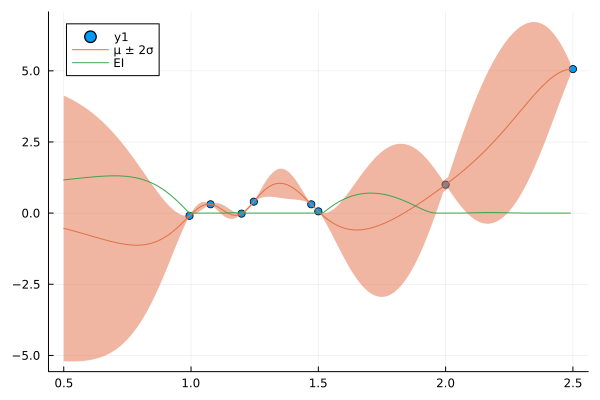

In [71]:
domain = filter(x -> !(x in X), lbs[1]:.01:ubs[1])
scatter(sur.X', sur.y)
plot!(domain, [sur([x]).μ for x in domain],
    ribbons=2*[sur([x]).σ for x in domain], label="μ ± 2σ")
plot!(domain, [sur([x]).EI for x in domain], label="EI")

In [72]:
sur.ψ.θ

2-element Vector{Float64}:
 5.904615925446598
 0.2865493128512049

In [73]:
sur.X

1×8 Matrix{Float64}:
 2.0  2.5  0.993948  1.47225  1.19852  1.07671  1.5  1.24665